# Import

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model

In [38]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [40]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [42]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [44]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_

In [46]:
df.shape

(226, 49)

# Stationarity Check

In [49]:
result = adfuller(df['nonglu_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -3.302824716654775
p-value: 0.014752680770463844
Critical Values:
   1%: -3.4604283689894815
   5%: -2.874768966942149
   10%: -2.57382076446281


In [51]:
# ADF Statistic = -3.303
# A highly negative value generally indicates evidence against the null hypothesis 
# (non-stationarity). However, the magnitude alone is not the only determinant; 
# the test's critical values must also be considered for confirmation.

# More negative than both the 5% (-2.875) and 10% (-2.574) critical values
# But not more negative than the 1% critical value (-3.460)
# This means one can reject the null hypothesis of non-stationarity at the 5% confidence level 
# (which we're using down below) but not at the 1% level (which is basically fine here)
# The p-value of 0.015 confirms this, as it's less than 0.05 but greater than 0.01

# p-value = 0.015
# This is less than the standard 0.05 significance level
# Therefore, we reject the null hypothesis of non-stationarity
# This output justifies rejecting the null hypothesis that the series is non-stationary.

# Model

In [54]:
# Create the differenced target
y = df['nonglu_price'].diff().dropna()

# Define independent variables (predictors) list
xvars = ['hommali_price', 'agri_prod_index', 'crops_prod_index',
        'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index', 'agri_export_value',
       'rice_export_value', 'ricet_export_amount', 'cpi', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6','water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'water_station_Y17', 'water_station_Y1C']

# Adjust X to match the same periods
# Remove the first row to match diff_data
X = df[xvars].iloc[1:]

# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=20)

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((205, 46), (20, 46), (205,), (20,))

## Model 1 : ARIMAX

In [60]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)

y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

model_1 = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [63]:
# model_1.summary()

In [65]:
# Generate predictions on the test set
preds_1 = model_1.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [67]:
# Evaluate the model_1
model_1_mse = mean_squared_error(y_test, preds_1)
model_1_mse

1617299.1014717766

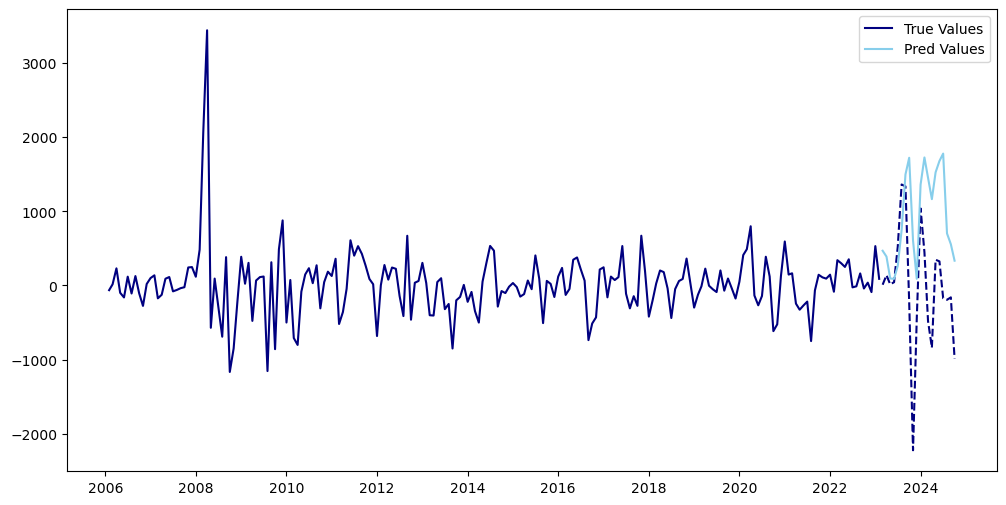

In [69]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(preds_1, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## Model 2 : ARIMAX with hyperparameter

In [ ]:
# Define the range of p, d, q values to search
p_values = range(0, 3)
d_values = range(0, 1)
q_values = range(0, 3)

# Prepare a list of all combinations
param_combinations = list(itertools.product(p_values, d_values, q_values))

# Store results
best_params = None
best_mse = float("inf")
results = []

# Iterate through parameter combinations
for params in param_combinations:
    try:
        model = ARIMA(y_train, exog=X_train, order=params, freq='MS').fit()
        # Only evaluate if model converged
        if model.mle_retvals['converged']:
            preds = model.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
            mse = mean_squared_error(y_test, preds)
            results.append((params, mse))
            if mse < best_mse:
                best_mse = mse
                best_params = params
    except Exception as e:
        continue

# Display the best parameters
print(f"Best Parameters: {best_params}, MSE: {best_mse}")

# Create a DataFrame of results for inspection
results_df = pd.DataFrame(results, columns=["Parameters", "MSE"])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
model_2 = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog=X_train,      # External variables 
    order=(0, 0, 1),   # ARIMA parameters: (p=0, d=0, q=1)
    freq = 'MS'        # Monthly data
).fit()

In [ ]:
# Generate predictions on the test set
preds_2 = model_2.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [ ]:
# Evaluate the model_2
model_2_mse = mean_squared_error(y_test, preds_2)
model_2_mse

In [ ]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(preds_2, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## Model 3 : Auto_arima

In [ ]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train, 
    exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,                  # Automatically determine 'd'
    seasonal=False,  
    trace=True,              # Show the tuning process
    error_action='ignore',   # Skip invalid configurations
    suppress_warnings=True,
    stepwise=True            # Use stepwise search to reduce computation
)

# Best parameters
print(auto_model.summary())

In [ ]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
model_3 = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog=X_train,      # External variables 
    order=(1, 0, 0),   # ARIMA parameters: (p=0, d=0, q=1)
    freq = 'MS'        # Monthly data
).fit()

In [ ]:
# Generate predictions on the test set
preds_3 = model_3.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [ ]:
# Evaluate the model_3
model_3_mse = mean_squared_error(y_test, preds_3)
model_3_mse

In [ ]:
# Plot 
plt.figure(figsize=(12, 6))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed')
plt.plot(preds_3, c='skyblue', label='Pred Values')
plt.legend()
plt.show()

## Model 4 : Hyperparameter tuning with Keras Tuner

In [37]:
def build_time_series_model(hp, input_shape=(20,1)):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    # Store number of LSTM layers once to avoid repeated calls
    n_lstm_layers = hp.Int('lstm_layers', 1, 3)
    
    # LSTM layers
    for i in range(n_lstm_layers):
        units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32)
        return_sequences = i < n_lstm_layers - 1
        
        # Add LSTM with regularization
        x = tf.keras.layers.LSTM(
            units, 
            return_sequences=return_sequences,
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )(x)
        
        # Add dropout after each LSTM layer
        x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.3, step=0.1))(x)

    # Dense layers with fixed dropout
    x = tf.keras.layers.Dense(
        hp.Int('dense_units', 16, 128, step=16),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)

    # Model compilation
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')
        ),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model